# Napredni OCR
Na vežbama #2 smo razvijali naš OCR alat koji je pokazao dobre performanse na kreiranim slikama. Međutim, kada smo isti pristup primenili za kompleksnije slike, kao što su bile na izazovu #2, videli smo da je potrebno proširiti funkcionalnosti alata kako bi se dobile zadovoljavajuće performanse. Kompleksniji algoritmi za segmentaciju i detekciju karaktera, napradniji klasifikator, rešavanje problema rotacije, više redova itd.

Gotova rešenja pokrivaju većinu ovih funkcionalnost, tako da za bilo koju sliku možemo kao rezultat da dobijemo njen tekst. Neki od popularnih alata su:
1. Tesseract
2. Microsoft Vision
3. Google Vision
4. Abbyy

Na ovim vežbama, mi ćemo koristiti Tesseract, ali slično ponašanje i parametre možete očekivati i od ostalih alata.

## Tesseract
Tesseract OCR je najpopularniji open source OCR alat razvijen od strane kompanije Google. Popularnost i široku upotrebu je postigao zahvaljujući podršci za različite jezike, ali i fleksibilnosti da se lako dodaju i novi.

#### Upotreba kroz komandnu liniju
```tesseract FILE OUTPUTBASE [OPTIONS]... [CONFIGFILE]..```

Primer čitanja fajla `image.png` i ispis texta u konzoli `stdout`

```tesseract image.png stdout```

#### Dodatne opcije
Tesseract nudi mnoštvo dodatnih opcija kako bi se njegova upotreba najbolje prilagodila zadatom problemu. Postoje opcije za izbor samog jezika `-l`, izbor modela `--oem` i ostale. Mi ćemo posebnu pažnju posvetiti opciji koje definiše na koji način će biti uzvršena segmentacija slike, što se može postići sa parametrom `--psm`. Spisak svih podržanih modova segmentacije se nalazi ispod (`tesseract help-extra` komanda daje spisak svih dodatnih parametara.

```
Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.
```

## PyOCR

Tesseract je moguće koristiti kroz sve programske jezike, jer sve biblioteke implementiraju omotač oko naredbi koje se pozivaju kroz komandnu liniju. Mi smo se opredelili za PyOCR biblioteku zbog jednostavnosti upotrebe.

In [37]:
import cv2
from PIL import Image
import sys

import pyocr
import pyocr.builders

import matplotlib
import matplotlib.pyplot as plt

# iscrtavanje slika i plotova unutar samog browsera
%matplotlib inline 
# prikaz vecih slika 
matplotlib.rcParams['figure.figsize'] = 16,12

# PyOCR podrzava i neke druge alate, tako da je potrebno proveriti koji su sve alati instalirani
tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("No OCR tool found")
    sys.exit(1)
    
# odaberemo Tessract - prvi na listi ako je jedini alat
tool = tools[0]
print("Koristimo backend: %s" % (tool.get_name()))
# biramo jezik očekivanog teksta
lang = 'eng'

Koristimo backend: Tesseract (sh)


### Učitavanje slike
Tesseract podržava rad sa slikama u boji, grayscale i binarnim slikama. Takođe, moguće je primeniti 

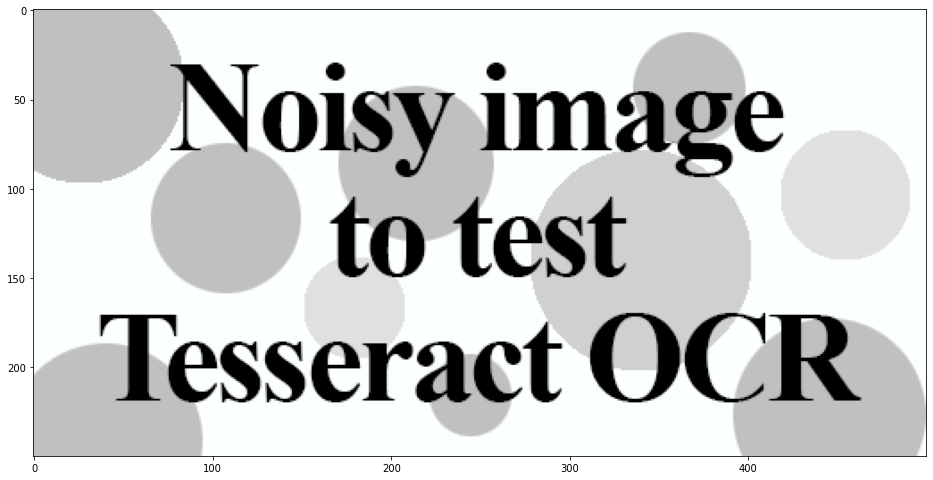

In [43]:
image = cv2.imread('example_01.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

#### Izlaz Python string
`TextBuilder` kao rezultat vraća Python string koji sadrži pročitani tekst. Za izbor segmentacije, može se koristiti `tesseract_layout` parametar (default vrednost je 3).

In [44]:
text = tool.image_to_string(
    Image.fromarray(image),
    lang=lang,
    builder=pyocr.builders.TextBuilder(tesseract_layout=3) # izbor segmentacije (PSM)
)
# txt is a Python string
text

'Noisyimage\nto test\nTesseract OCR'

#### Izlaz lista reči sa tekstom, koordinatama i faktorom sigurnosti
Pored samog teksta, možemo da dobijemo i informaciju o koordinatama gde je neka reč pronađena na slici, njen sadržaj, kao i faktor sigurnosti da smo dobro prepoznali reč

In [45]:
word_boxes = tool.image_to_string(
    Image.fromarray(image),
    lang=lang,
    builder=pyocr.builders.WordBoxBuilder(tesseract_layout=3)
)
for i, box in enumerate(word_boxes):
    print("word %d" %i)
    print(box.content, box.position, box.confidence)
    print()

word 0
Noisyimage ((77, 30), (420, 94)) 75

word 1
to ((166, 105), (219, 150)) 95

word 2
test ((235, 105), (332, 150)) 96

word 3
Tesseract ((38, 171), (296, 220)) 94

word 4
OCR ((312, 170), (464, 220)) 96



#### Izlaz po redovima
Moguće je na osnovu segmentacije grupisati reči po redovima

In [46]:
line_and_word_boxes = tool.image_to_string(
     Image.fromarray(image), lang=lang,
    builder=pyocr.builders.LineBoxBuilder(tesseract_layout=3)
)
for i, line in enumerate(line_and_word_boxes):
    print('line %d' %i)
    print(line.content, line.position)
    print('boxes')
    for box in line.word_boxes:
        print(box.content, box.position, box.confidence)
    print()

line 0
Noisyimage ((77, 30), (420, 94))
boxes
Noisyimage ((77, 30), (420, 94)) 75

line 1
to test ((166, 105), (332, 150))
boxes
to ((166, 105), (219, 150)) 95
test ((235, 105), (332, 150)) 96

line 2
Tesseract OCR ((38, 170), (464, 220))
boxes
Tesseract ((38, 171), (296, 220)) 94
OCR ((312, 170), (464, 220)) 96



#### Detekcija brojeva
Nekada se može javiti potreba da se prepoznaju samo određeni karakteri kao na primer brojevi. U tom slučaju se može koristiti `DigitalBuilder`. U ovakvim slučajevima je potrebno odabrati pravi mod segmentacije.

In [47]:
image_digits = cv2.imread('test-digits.png')
image_digits = cv2.cvtColor(image_digits, cv2.COLOR_BGR2RGB)
digits = tool.image_to_string(
    Image.fromarray(image_digits),
    lang=lang,
    builder=pyocr.tesseract.DigitBuilder(tesseract_layout=7) # ocekivani text je single line, probati sa 3,4,5..
)
digits

'328308'